# Fisher Transformation
## Making distributions more Gaussian.

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [2]:
# First import useful tools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# And define the windows for the normalization
norm_window = 20

In [3]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
df = (data.HIGH - data.LOW) / 2

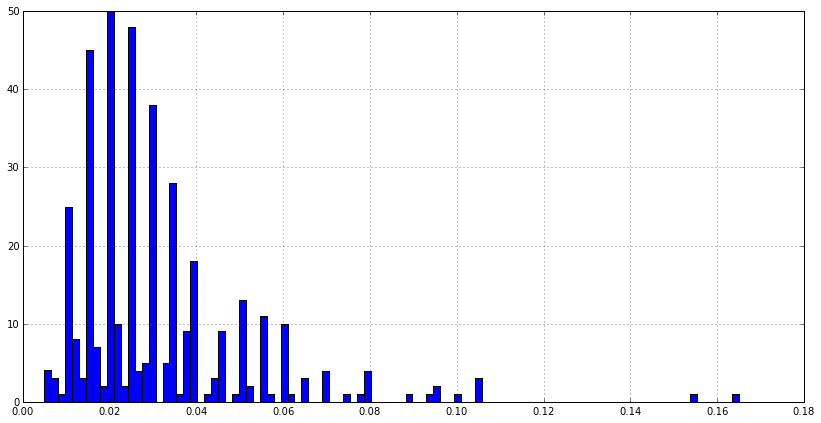

In [4]:
df.hist(bins=100)

In [5]:
def fisher(df, norm_window):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / (pd.rolling_max(df, norm_window) - \
                                                        pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Smoothing df_value by applying EMA with alpha 0.5.
    df_value = 0.5 * df_value + 0.5 * df_value.shift()
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    # Estimate the Fisher transform and smoothing again with an EMA with alpha 0.5.
    df_fisher = 0.5 * np.log((1 + df_value) / (1 - df_value))
    return 0.5 * df_fisher + 0.5 * df_fisher.shift()

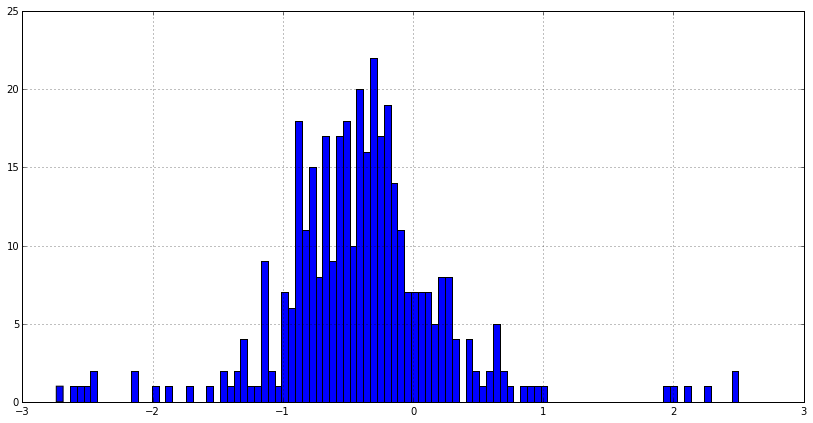

In [6]:
df_fisher = fisher(df, norm_window)
df_fisher.hist(bins=100)

In [7]:
df_fisher_osc = pd.concat([df_fisher, df_fisher.shift()], axis=1)
df_fisher_osc.columns = ["Fisher", "Trigger"]

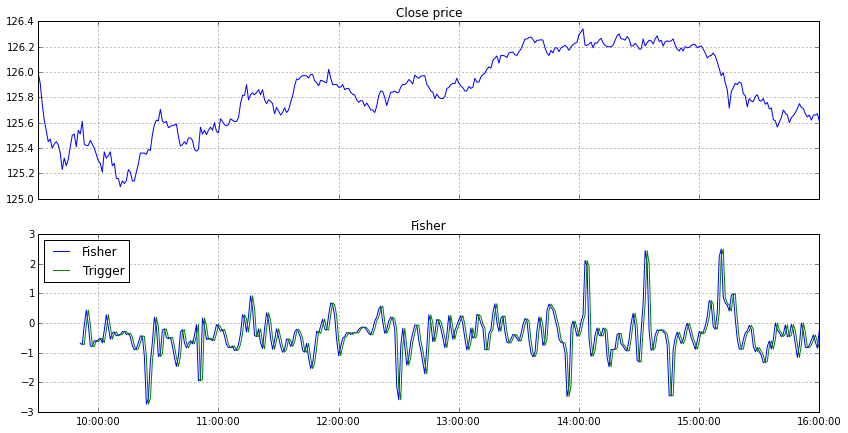

In [8]:
f, axarr = plt.subplots(2, sharex=True)
x = df.index
axarr[0].plot(x, data.CLOSE)
axarr[0].set_title('Close price')
axarr[0].grid()
axarr[1].plot(x, df_fisher_osc.Fisher, label='Fisher')
axarr[1].plot(x, df_fisher_osc.Trigger, label='Trigger')
axarr[1].legend(loc='upper left')
axarr[1].set_title('Fisher')
axarr[1].grid()

## Inverse Fisher Transform

In [9]:
def fisher_inverse(df, norm_window):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / (pd.rolling_max(df, norm_window) - \
                                                        pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Smoothing df_value by applying EMA with alpha 0.5.
    df_value = 0.5 * df_value + 0.5 * df_value.shift()
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    df_inverse_fisher = (np.exp(2*df_value) - 1) / (np.exp(2*df_value) + 1)
    return 0.5 * df_inverse_fisher + 0.5 * df_inverse_fisher.shift()

In [10]:
df_fisher_inverse = fisher_inverse(df, norm_window)

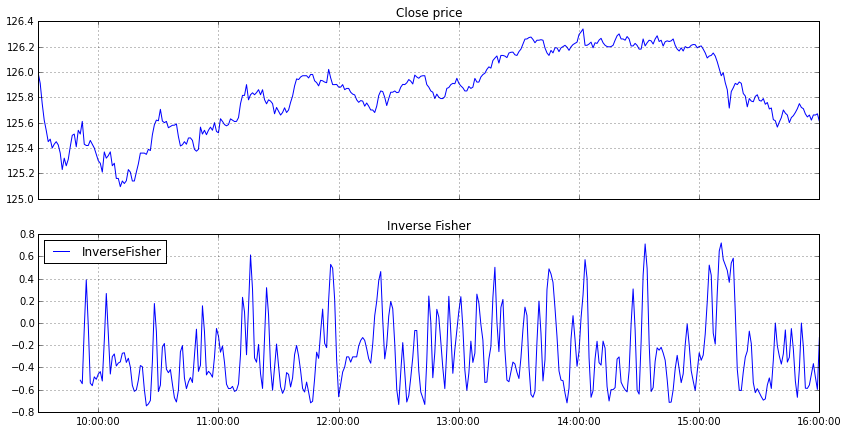

In [11]:
f, axarr = plt.subplots(2, sharex=True)
x = df.index
axarr[0].plot(x, data.CLOSE)
axarr[0].set_title('Close price')
axarr[0].grid()
axarr[1].plot(x, df_fisher_inverse, label='InverseFisher')
axarr[1].legend(loc='upper left')
axarr[1].set_title('Inverse Fisher')
axarr[1].grid()